<a href="https://colab.research.google.com/github/HectorMaravillo/StreetNetworks/blob/main/NetworkStreet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Distribuciones de probabilidad de la red de calles**

Author: Héctor Maravillo

e-mail: hector.maravillo@im.unam.mx

Instituto de Matemáticas Unidad Cuernavaca, UNAM

Abril 2022

-------------------------------------------

Se extraen redes de calles de OpenStreetMaps a partir del centro de la ciudad y la longitud de un cuadrado delimitador.

Los elementos mostrados son los siguientes:


1.   Mapa de la red de calles.
2.   El histograma polar de la orientación de las calles ponderada por su longitud. La orientación se mide respecto a una recta vertical de sur a norte. Una gráfica en forma de cruz indica la presencia de una estructura en forma de cuadrícula (Mérida), mientras que una forma de circulo indica una estructura irregular (Guanajuato).
3. Los mapas de la centralidad de intermediación (*betweenneess centrality*) por vértice y por aristas. Mide la importancia de un vértice o arista respecto a las rutas más cortas entre pares de nodos. El color amarillo representa los elementos de mayor centralidad, y el color morado la menor centralidad.

Las formulas son:

Centralidad de Intermediación del vértice $i$

$$ g(i) = \frac{1}{n}\sum_{s\neq t}\frac{\sigma_{st}(i)}{\sigma_{st}}$$

Centralidad de intermediación de la arista $e$

$$ g(e) = \frac{1}{(n-1)(n-2)}\sum_{s\neq t}\frac{\sigma_{st}(e)}{\sigma_{st}}$$

Donde $\sigma_{st}(.)$ es el número de rutas más cortas entre los vértices $s$ y $t$ que pasan por el elemento $.$ (un vértice o una arista) y $\sigma_{st}$ el número de rutas más cortas entre $s$ y $t$. El número de vértices se denota con $n$. 


4. Distribución de la centralidad de intermediación por vértice y arista. 

5. Distribución de grado.

6. Distribución de longitud de los segmentos de calle.

7. Distribución del área de las manzanas estimadas por las caras de la red de calles.

Las gráficas 6 y 7 son preliminares, ya que se extrae la red a partir de un cuadro delimitador lo cual puede incluir zonas no urbanizadas. Esto podría explicar la existencia de cola pesada en ambas graficas. Esto cambiará cuando se utilizen los datos de los ejes viales del INEGI.

8. Distribución del factor de forma de las manzanas estimadas.  El factor de forma (*shape factor*) se calcula como:
$$\phi = \frac{4A}{\pi D^2}$$
donde $A$ es el área de la cara y $D$ es la longitud más grande entre un par de vértices del polígono que define la cara. El factor de forma varía entre 0 y  1. Por ejemplo, $\phi \approx 0.6$ es el valor que toma una manzana cuadrada. Mientras que un valor de $\phi$ cercano a 0 puede indicar que el polígono de la manzana es muy irregular o alargado.


## **Instalación de paquetes**

In [ ]:
# Intalar las librerías. Despues reiniciar el entorno de ejecución y saltar esta celda.
!pip install --upgrade pyshp
!pip install --upgrade rtree
!pip install --upgrade pygeos
!pip install --upgrade shapely
!pip install --upgrade descartes
!pip install --upgrade geopandas
!pip install --upgrade osmnx
!pip install --upgrade matplotlib
!pip install ipython-autotime

In [ ]:
%load_ext autotime
%matplotlib inline

In [ ]:
# Librerías
import numpy as np                        # Cálculo numérico y análisis de datos
import geopandas as gpd                   # Análisis de datos geográficos
import matplotlib.pyplot as plt           # Construcción de gráficas
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sb                      # Construcción de gráficas
import osmnx as ox                        # Extracción de redes de vialidades de OpenStreetMap
import networkx as nx                     # Construcción y análisis de gráficas y digráficas
import shapely                            # Manipulación de figuras geométricas en el plano (puntos, polilineas y polígonos)
import pandas as pd                       # Análisis y manipulación de datos

from itertools import combinations        # Combinaciones de un conjunto

## **Variables generales**

In [ ]:
projection     = 6372
distance       = 2000
bins           = 30
buffer         = 2
fontsize_title = 14
fontsize_label = 10

## **Definición de funciones**

In [ ]:
def Extract_StreetNetwork(city_name, distance):
  """ Extrae la red de calles dada una dirección y una distancia como una gráfica no dirigida de OpenStreetMap"""
  G = ox.graph_from_address(city_name, dist = distance, truncate_by_edge = False, network_type = "drive")
  G = ox.add_edge_bearings(G)
  G = G.to_undirected()
  return G

def  Extract_Length(G):
  """ Extrae longitud de la gráfica de calles de OpenStreetMap"""
  l      = []
  for e in G.edges(data=True):
    l.append(e[2]["length"])
  length = np.array(l)
  length = np.sort(length)
  return length

def Extract_Degree(G):
  """ Extrae la secuencia de grado de una gráfica"""
  degree_sequence = np.array([d for n, d in G.degree()])
  degree_sequence = np.sort(degree_sequence)
  return degree_sequence

def Calculate_ShapeFactor(polygon):
  exterior_points =  np.array(polygon.exterior.coords) 
  radius          = 0
  for pair in combinations(exterior_points,2):
    d  = np.linalg.norm(pair[0]-pair[1])
    if d > radius:
      radius = d
  shape_factor = (4*polygon.area)/(np.pi*np.power(radius,2))
  return shape_factor

def Extract_Blocks(G, buffer):
  """ Estima la geometría de las manzanas a partir de una red de calles de OSM """
  intersection, streets = ox.graph_to_gdfs(G)
  intersection.to_crs(projection, inplace = True)
  streets.to_crs(projection, inplace = True)
  convexhull            = intersection.geometry.unary_union.convex_hull
  streets_buffer        = streets.geometry.buffer(buffer)
  del intersection, streets
  streets_buffer        = streets_buffer.geometry.unary_union
  blocks_geometry       = convexhull.difference(streets_buffer)
  blocks                = gpd.GeoDataFrame()
  if blocks_geometry.type   == "MultiPolygon":
    blocks["geometry"]      = blocks_geometry.geoms
  elif blocks_geometry.type == "Polygon":
    blocks["geometry"]      = blocks_geometry
  blocks.set_crs(projection)
  blocks["Area"]        = blocks.geometry.area
  blocks["ShapeFactor"] = blocks.geometry.apply(Calculate_ShapeFactor)
  return blocks

def Extract_BetweennessCentrality(G, type_BC = "nodes"):
  if type_BC == "nodes":
    node_centrality = nx.betweenness_centrality(G = G, normalized=True, weight  = "length")
    return node_centrality
  elif type_BC == "edges":
    edge_centrality = nx.edge_betweenness(G=G, normalized=True, weight  = "length")
    return edge_centrality

In [ ]:
def Draw_Node_BetweennessCentrality(G, betweenness, ax):
  df = pd.DataFrame(data=pd.Series(betweenness).sort_values(), columns=['cc'])
  df['colors'] = ox.plot.get_colors(n=len(df), cmap='plasma')
  df = df.reindex(G.nodes())
  nc = df['colors'].tolist()
  fig, ax = ox.plot_graph(G, bgcolor='k',  ax = ax, node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1, show = False)

def Draw_Edge_BetweennessCentrality(G, betweenness, ax):
  # iterate over edges
  edges = []
  for i in betweenness.items():
      i = i[0] + (0,)
      edges.append(i)
  for i,j in zip(edges,betweenness.keys()): 
      betweenness[i] = betweenness[j]
      del betweenness[j]
  # color scale converted to list of colors for graph edges
  norm = colors.Normalize(vmin=min(betweenness.values()), vmax=max(betweenness.values())*0.5)
  cmap = cm.ScalarMappable(norm=norm, cmap=cm.plasma)
  ec = [cmap.to_rgba(cl) for cl in betweenness.values()]
  # color the edges in the original graph with betweeness centralities in the line graph
  fig, ax = ox.plot_graph(G, bgcolor='w', ax = ax, node_size=0, node_color='w', node_edgecolor='gray',
                          node_zorder=2, edge_color=ec, edge_linewidth=1.5, edge_alpha=1, show = False)

In [ ]:
def StreetNetworks_Analysis(G, city_name):
  G2 = nx.Graph(G)
  G3 = nx.MultiGraph(G2)
  node_centrality = Extract_BetweennessCentrality(G2, "nodes")
  edge_centrality = Extract_BetweennessCentrality(G2, "edges")
  degree = Extract_Degree(G2)
  length = Extract_Length(G2)
  blocks = Extract_Blocks(G3, buffer)

  fig = plt.figure(figsize = (10, 15))
  ax1 = fig.add_subplot(3,2,1)
  ax2 = fig.add_subplot(3,2,2, projection='polar')
  ax3 = fig.add_subplot(3,2,3)
  ax4 = fig.add_subplot(3,2,4)
  ax5 = fig.add_subplot(3,2,5)
  ax6 = fig.add_subplot(3,2,6)
  ax1.set_facecolor("black")
  ax2.set_facecolor("black")
  ax3.set_facecolor("black")
  ax4.set_facecolor("black")
  ox.plot_graph(G, show = False, ax = ax1, node_size  = 5)
  ax1.set_title("Network street (" + city_name + ")", {"fontsize": fontsize_title})
  ox.plot_orientation(G, ax = ax2, color='white', num_bins  = 36, weight = "length")
  ax2.set_title("Polar histogram of street orientation", {"fontsize": fontsize_title})
  Draw_Edge_BetweennessCentrality(G3, edge_centrality, ax3)
  ax3.set_title("Betweenness Centrality (by nodes)", {"fontsize": fontsize_title})
  Draw_Node_BetweennessCentrality(G3, node_centrality, ax4)
  ax4.set_title("Betweenness Centrality (by edges)", {"fontsize": fontsize_title})
  sb.histplot(edge_centrality, ax = ax5, bins = bins, stat = "probability")
  ax5.set_title("BC distribution (by edges)", {"fontsize": fontsize_title})
  sb.histplot(node_centrality, ax = ax6, bins = bins, stat = "probability")
  ax6.set_title("BC distribution (by nodes)", {"fontsize": fontsize_title})
  plt.show()
  plt.close()

  fig, ax = plt.subplots(2,2, figsize = (15,15))
  sb.histplot(degree, ax = ax[0][0], discrete = True, stat = "probability")
  ax[0][0].set_title("Degree distribution", {'fontsize':fontsize_title})
  ax[0][0].set_xlabel("Degree", {'fontsize': fontsize_label})
  ax[0][0].set_xticks(list(set(degree)))
  sb.histplot(length, ax = ax[0][1], bins = bins, stat = "probability", kde = True)
  ax[0][1].set_title("Length distribution of street segments", {'fontsize': fontsize_title})
  ax[0][1].set_xlabel("Length ($m$)", {'fontsize': fontsize_label})
  sb.histplot(blocks["Area"], ax = ax[1][0], bins = bins, stat = "probability", kde = True)
  ax[1][0].set_title("Block area distribution", {'fontsize': fontsize_title})
  ax[1][0].set_xlabel("Area ($m^2$)", {'fontsize': fontsize_label})
  sb.histplot(blocks["ShapeFactor"], ax = ax[1][1], bins = bins, stat = "probability", kde = True)
  ax[1][1].set_title("Blocks shape factor distribution", {'fontsize': fontsize_title})
  ax[1][1].set_xlabel("Shape factor $\phi$", {'fontsize': fontsize_label})
  plt.show()
  plt.close()

## **Mérida, Yucatán (2km)**

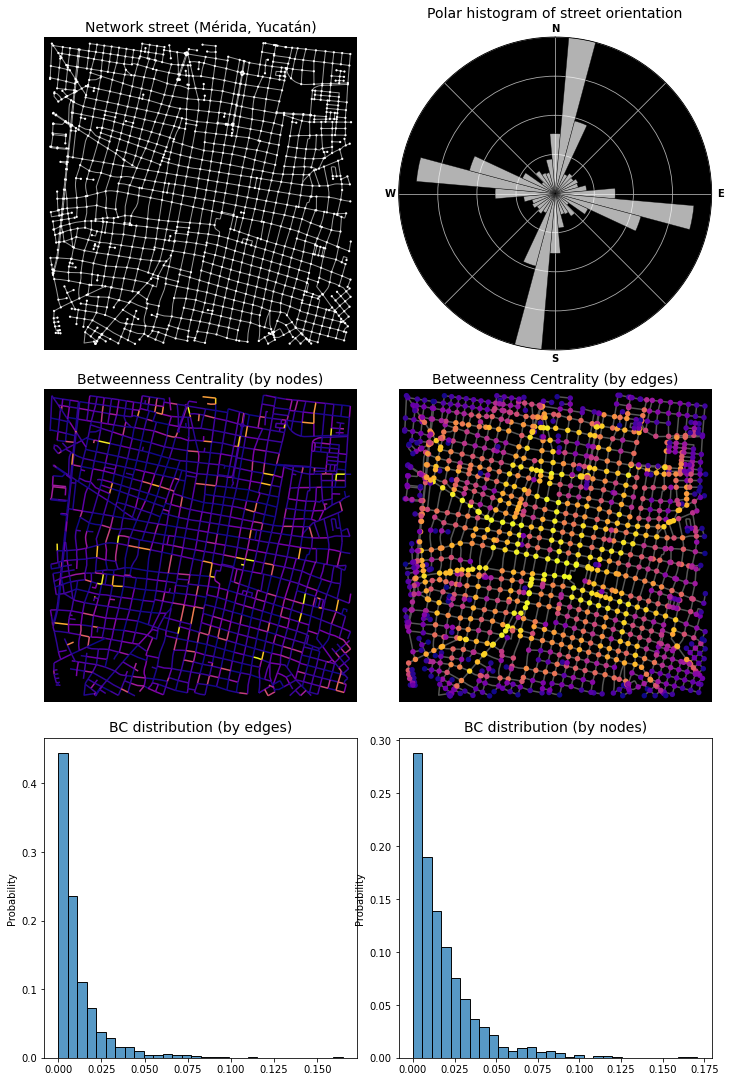

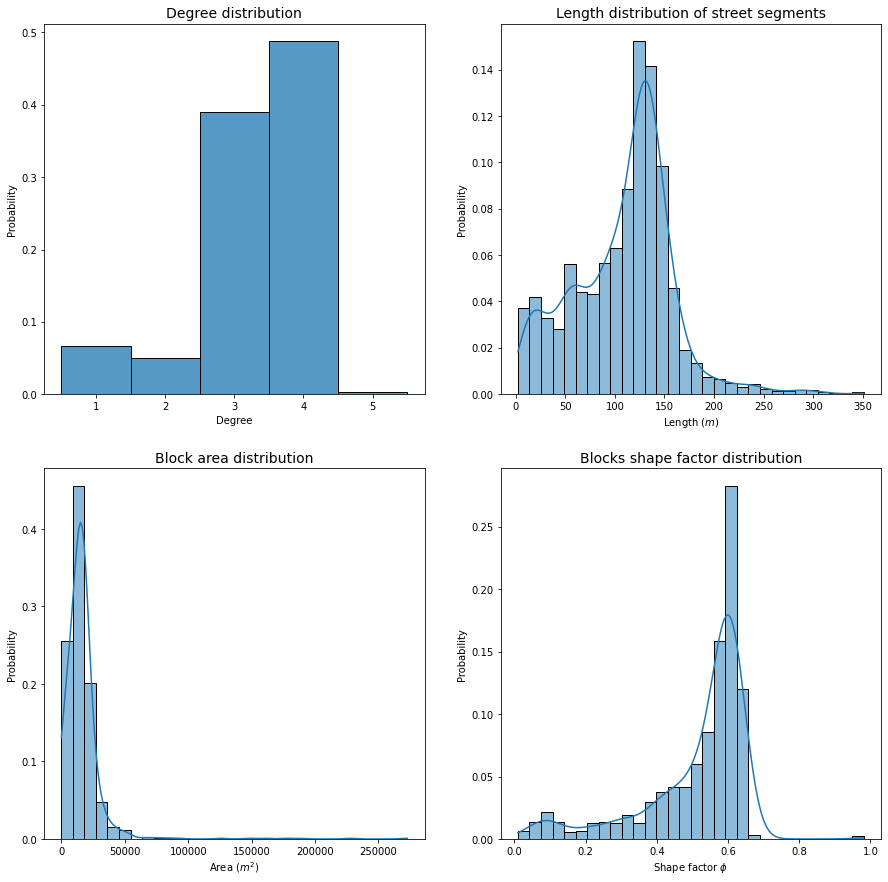

time: 51.8 s (started: 2022-04-13 00:15:36 +00:00)


In [7]:
city_name = "Mérida, Yucatán"
Mérida    = Extract_StreetNetwork(city_name, distance)
StreetNetworks_Analysis(Mérida, city_name)

## **Ciudad de México (2km)**

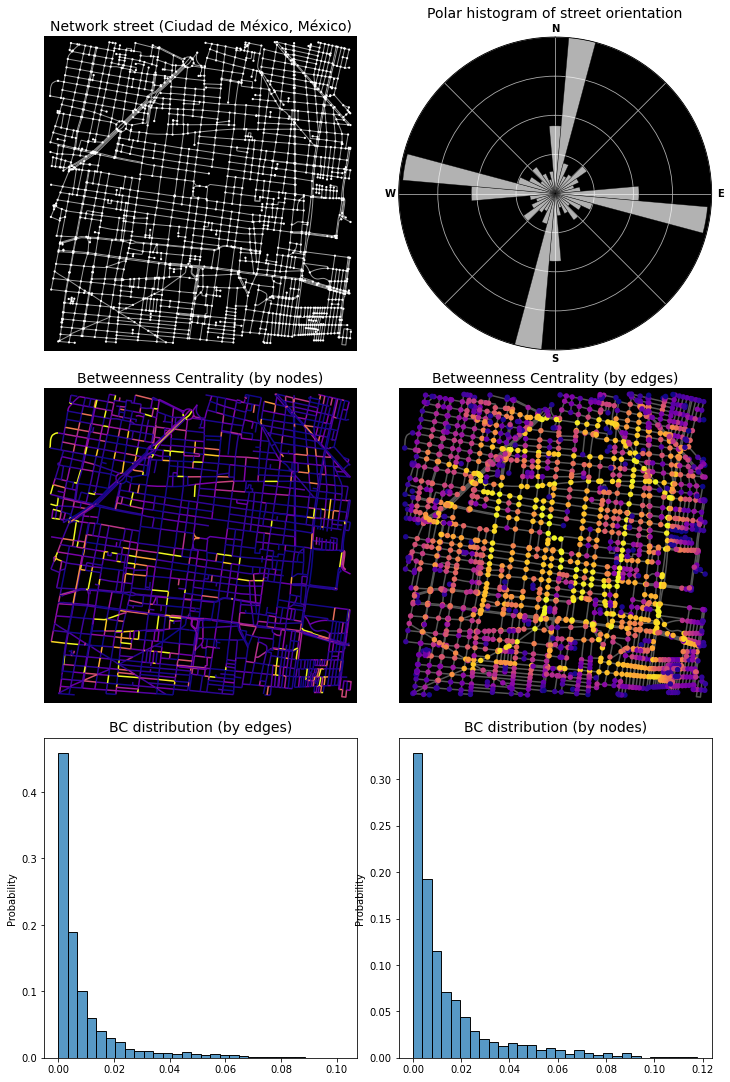

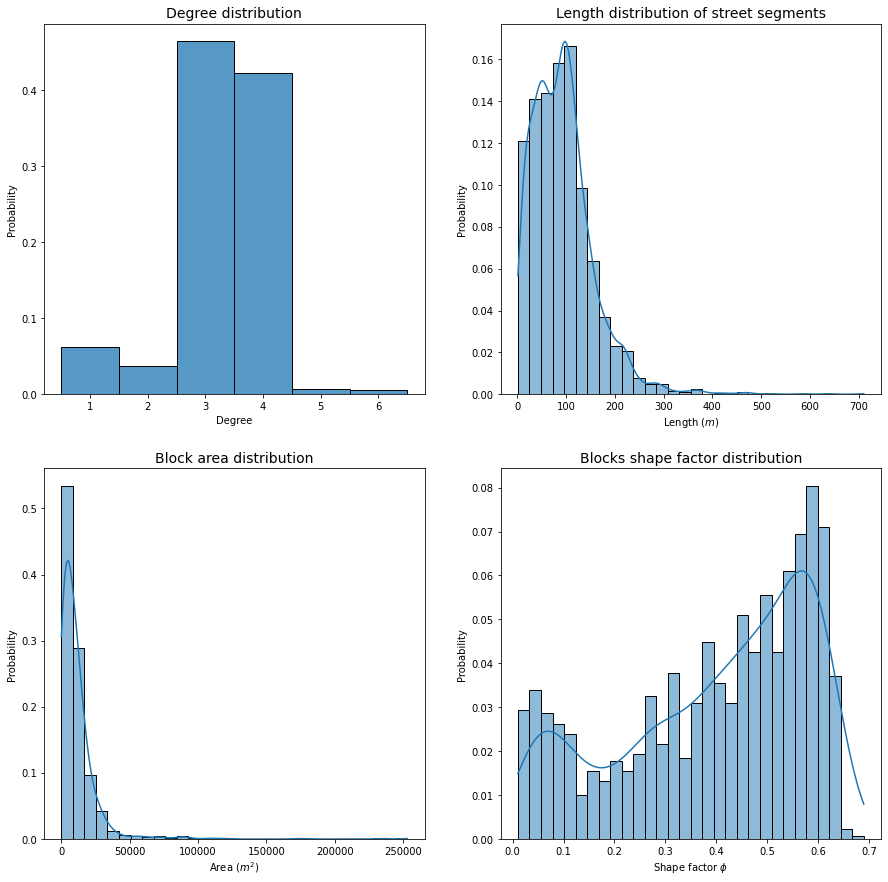

time: 1min 47s (started: 2022-04-13 00:16:28 +00:00)


In [8]:
city_name = "Ciudad de México, México"
Cdmx      = Extract_StreetNetwork(city_name, distance)
StreetNetworks_Analysis(Cdmx, city_name)

## **Cuernavaca, Morelos (2km)**

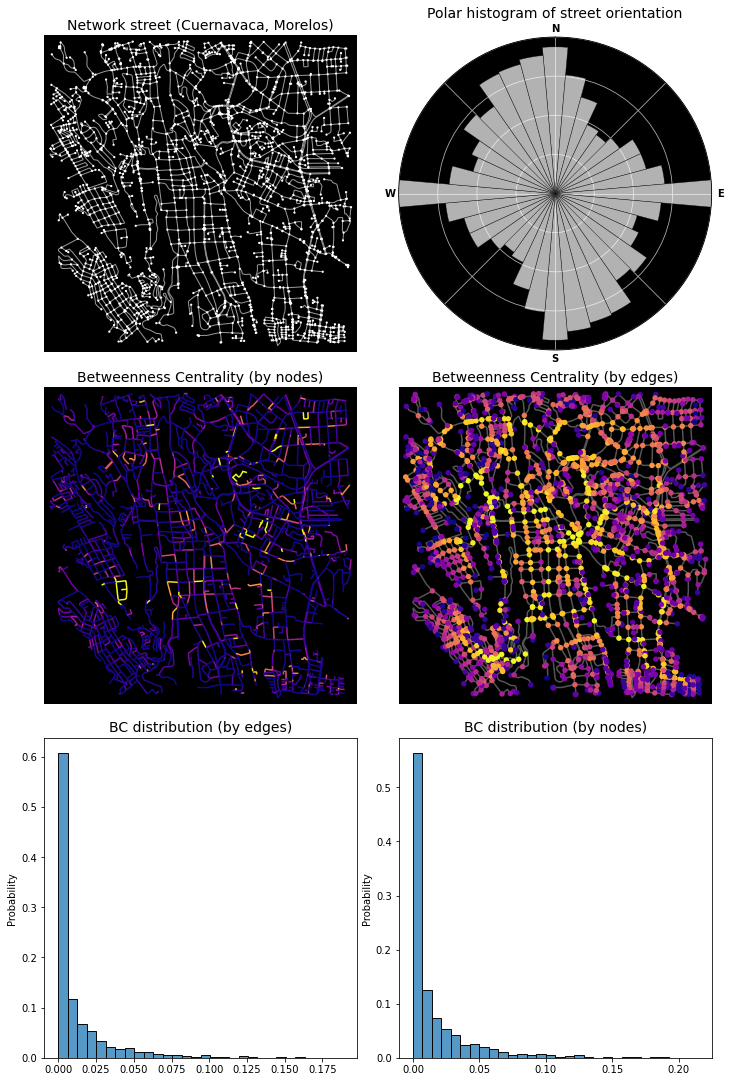

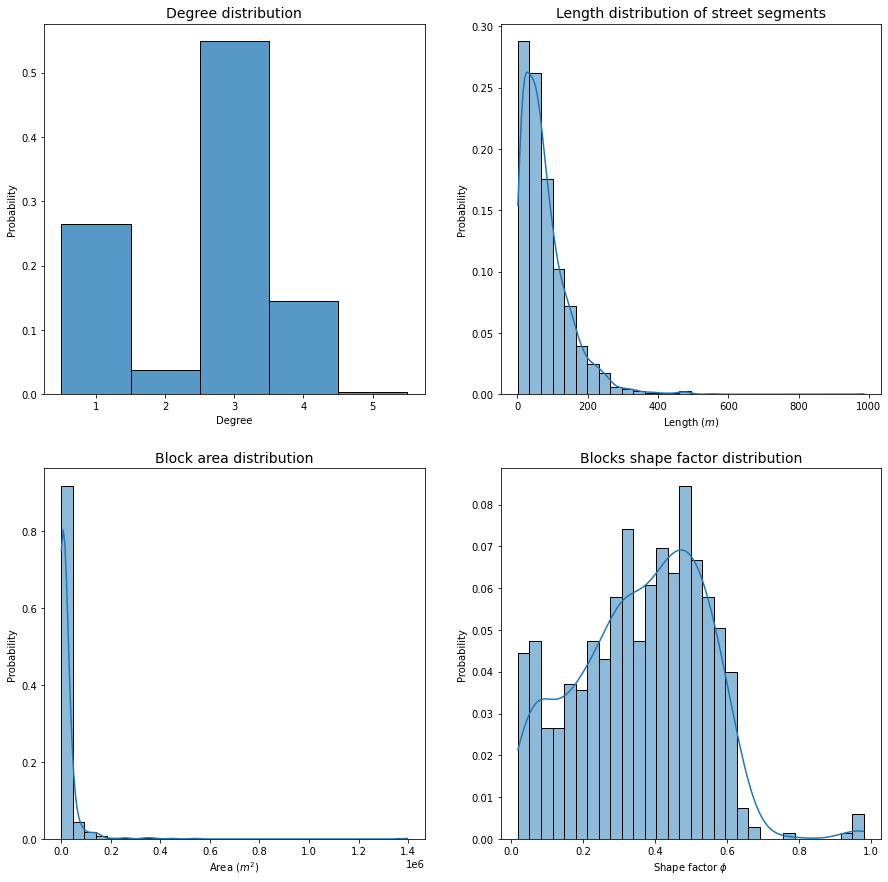

time: 3min 57s (started: 2022-04-13 00:18:15 +00:00)


In [9]:
city_name  = "Cuernavaca, Morelos"
Cuernavaca = Extract_StreetNetwork(city_name, distance)
StreetNetworks_Analysis(Cuernavaca, city_name)

## **Ciudad de Oaxaca (2km)**

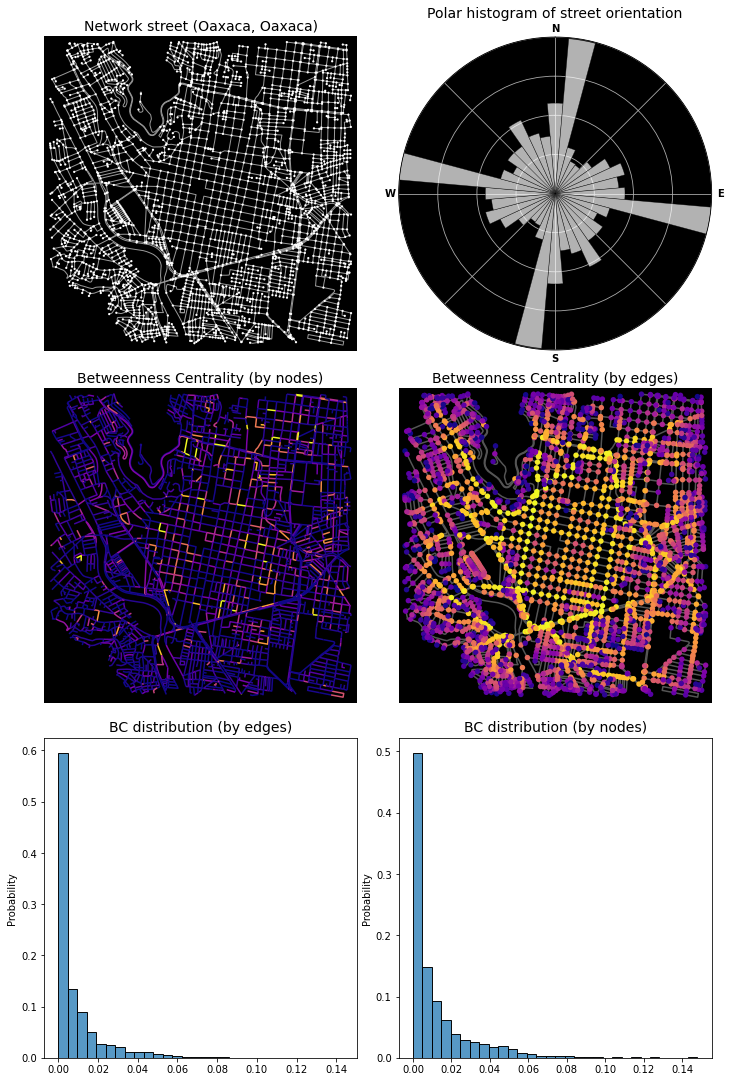

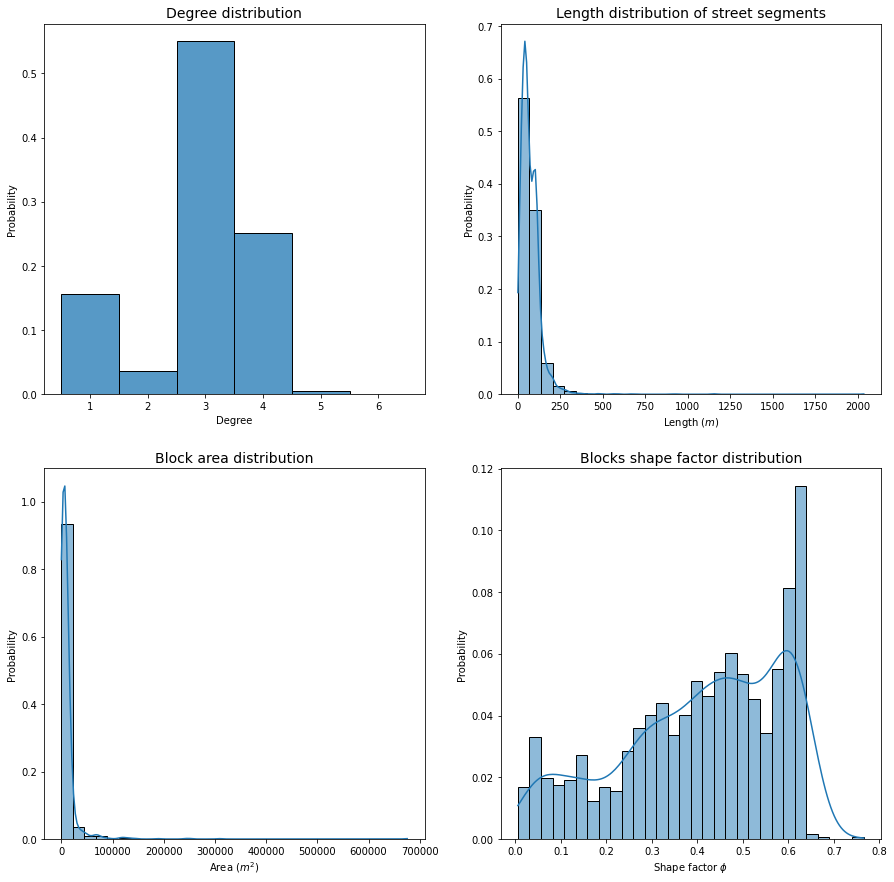

time: 3min 53s (started: 2022-04-13 00:22:13 +00:00)


In [10]:
city_name = "Oaxaca, Oaxaca"
Oaxaca    = Extract_StreetNetwork(city_name, distance)
StreetNetworks_Analysis(Oaxaca, city_name)

## **Ciudad de Guanajuato (2km)**



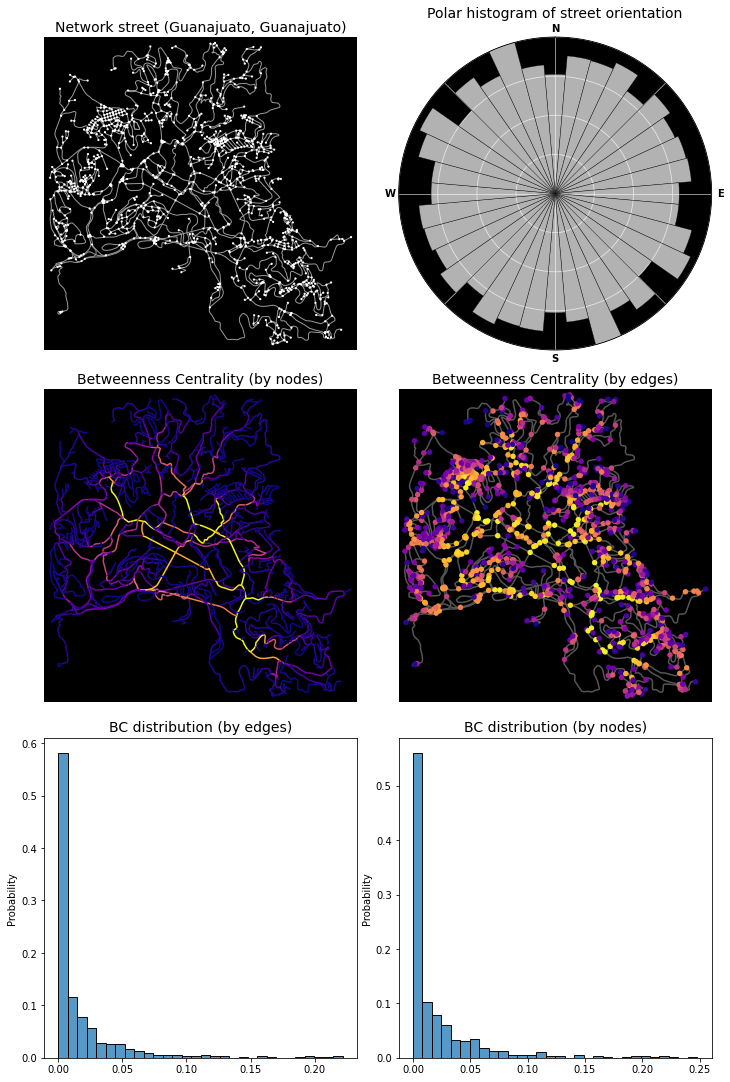

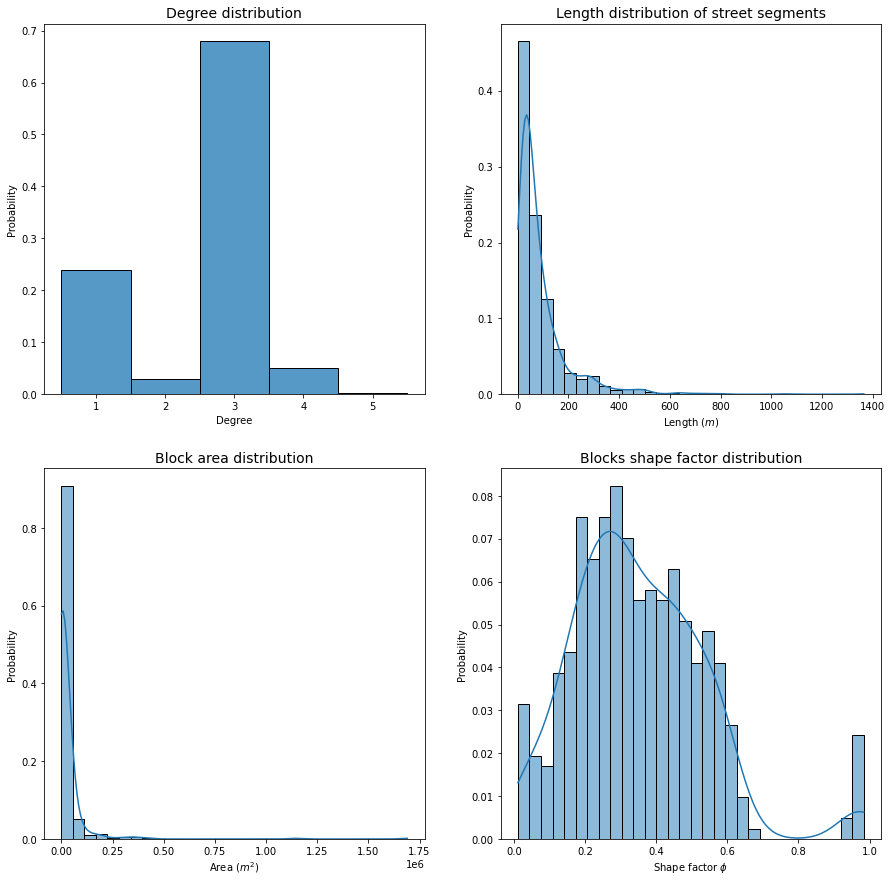

time: 1min 50s (started: 2022-04-13 00:26:06 +00:00)


In [11]:
city_name  = "Guanajuato, Guanajuato"
Guanajuato = Extract_StreetNetwork(city_name, distance)
StreetNetworks_Analysis(Guanajuato, city_name)

## **Ciudad de Acapulco (2km)**




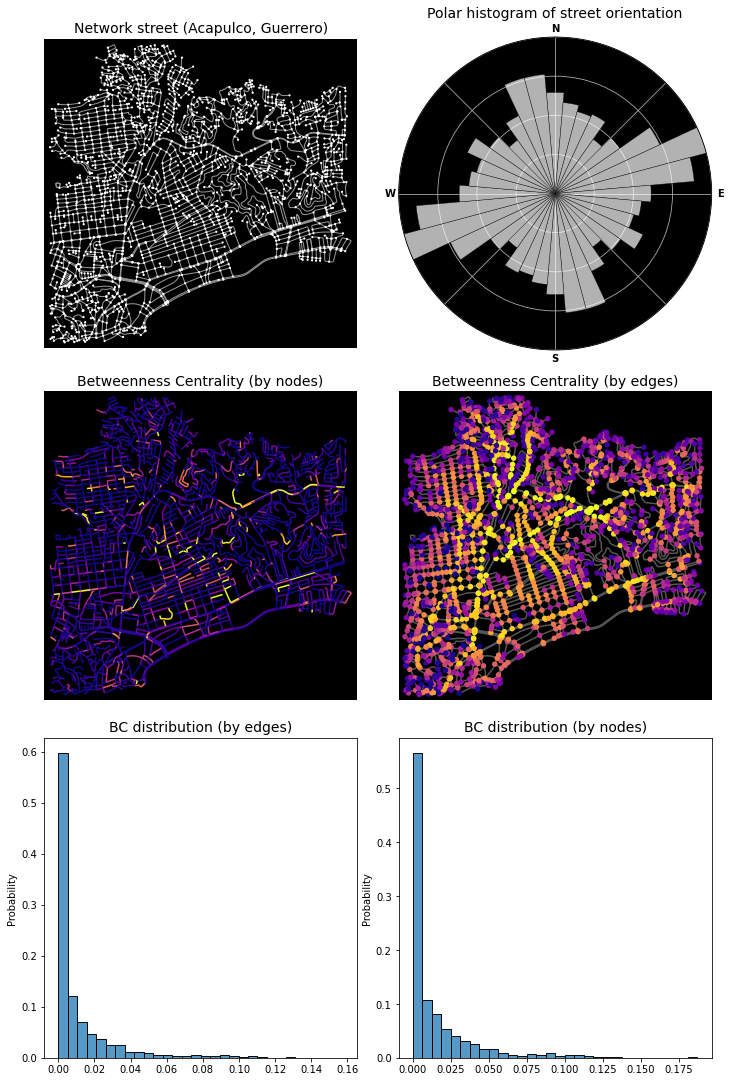

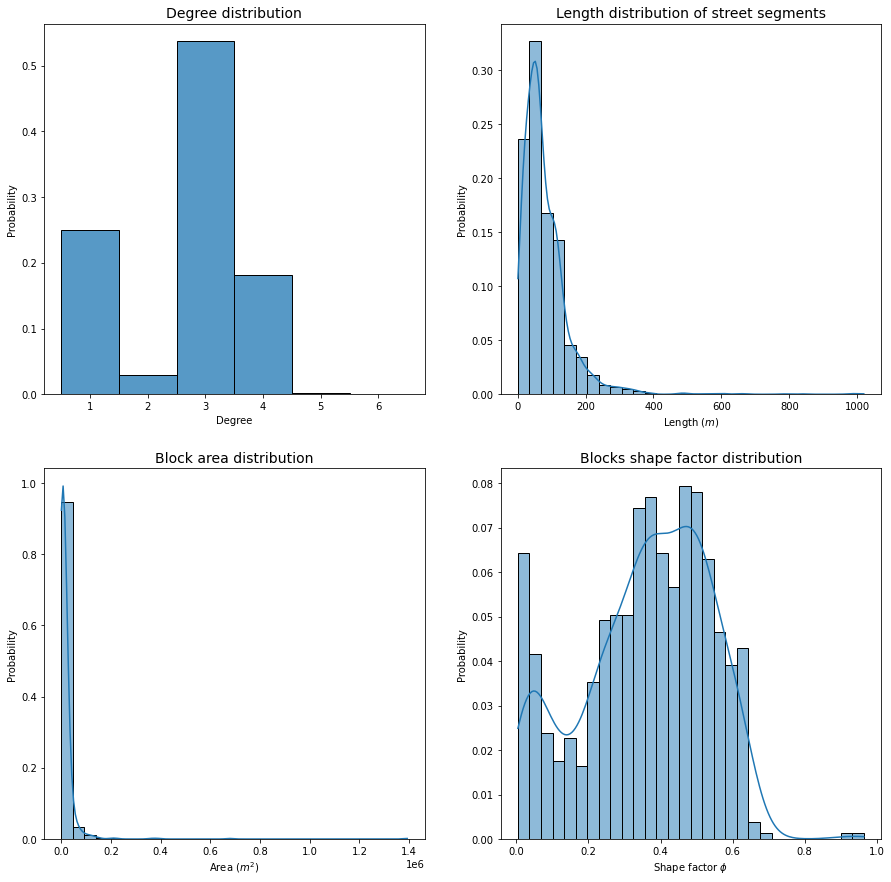

time: 4min 47s (started: 2022-04-13 00:27:57 +00:00)


In [12]:
city_name  = "Acapulco, Guerrero"
Acapulco = Extract_StreetNetwork(city_name, distance)
StreetNetworks_Analysis(Acapulco, city_name)

## **Cárdenas, Tabasco (10km)**

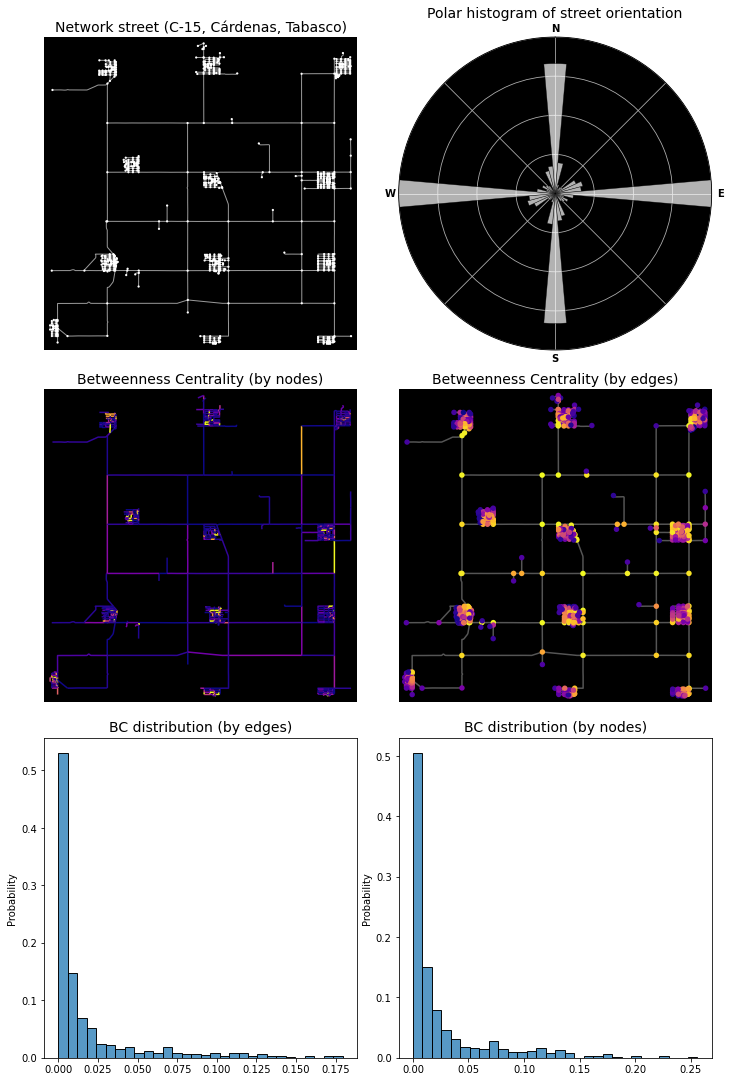

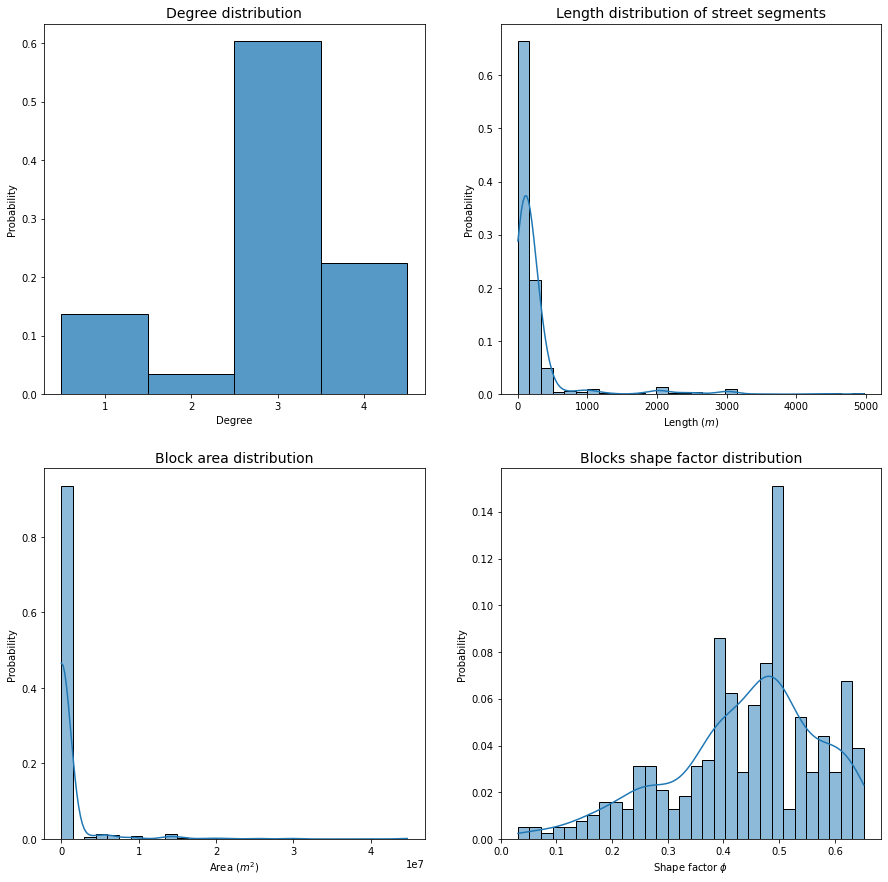

time: 29.2 s (started: 2022-04-13 00:32:45 +00:00)


In [13]:
city_name = "C-15, Cárdenas, Tabasco"
Cárdenas    = Extract_StreetNetwork(city_name, 10000)
StreetNetworks_Analysis(Cárdenas, city_name)

## **Tres Marías, Morelos (10km)**

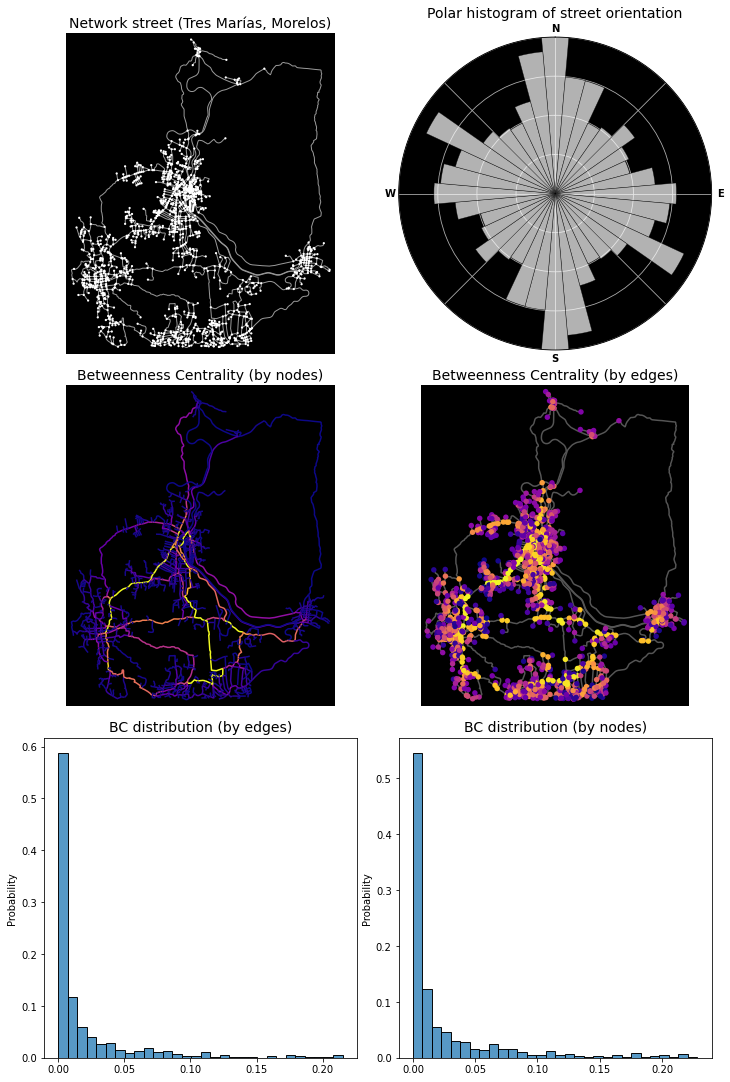

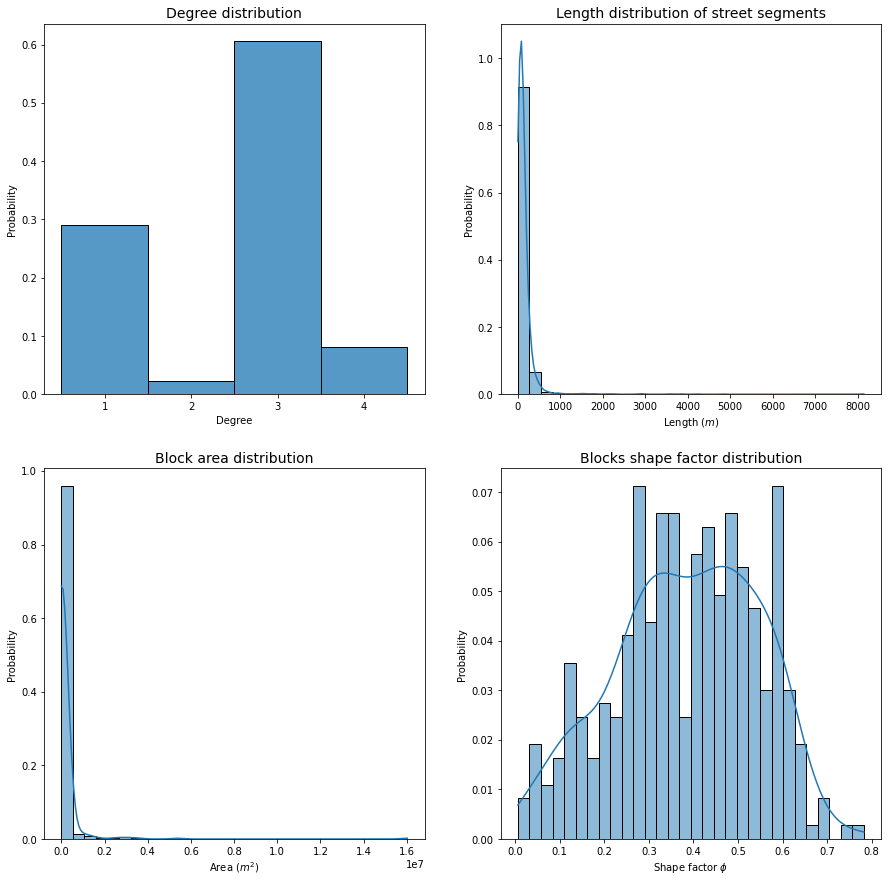

time: 3min 24s (started: 2022-04-13 00:33:14 +00:00)


In [14]:
city_name = "Tres Marías, Morelos"
Cárdenas    = Extract_StreetNetwork(city_name, 5000)
StreetNetworks_Analysis(Cárdenas, city_name)